In [1]:
#https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
#https://github.com/RaRe-Technologies
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
#https://github.com/lda-project/lda
#https://github.com/derekgreene/dynamic-nmf
#https://nlpforhackers.io/topic-modeling/
#https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
#https://docs.python.org/2/library/re.html
#https://pythonspot.com/nltk-stop-words/
#https://jakevdp.github.io/WhirlwindTourOfPython/14-strings-and-regular-expressions.html
#https://textblob.readthedocs.io/en/dev/advanced_usage.html
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
#https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#https://rare-technologies.com/tutorial-on-mallet-in-python/

In [1]:
import nltk
import gensim
import logging
import os
import re
import gensim
import spacy
import pyLDAvis
import en_core_web_sm
import warnings
import numpy as np
import pandas as pd
import gensim.corpora as corpora
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models.word2vec import Word2Vec
import pyLDAvis.sklearn
import pyLDAvis.gensim  # don't skip this

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from nltk.corpus import stopwords
#from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV


from muffnn import MLPClassifier
from pprint import pprint
from spacy.lang.en import English

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [2]:
df_review=pd.read_excel("../CannaConnect/Dataset/description_clean.xlsx")
#df_review=df_review.iloc[:,1]
df_review.head()

,Unnamed: 0,Description
0,0,og hybrid strain pack strong punch name sup...
1,1,aloha white widow especially potent cut white...
2,2,sativa dominant hybrid bred spain medical see...
3,3,dawgs hybrid g chemdawg genetics bred canadia...
4,4,known kosher tangie k gold indica dominant hy...


In [3]:
# Convert to list
data = df_review.values.tolist()

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['og', 'hybrid', 'strain', 'pack', 'strong', 'punch', 'name', 'supposedly', 'refers', 'strength', 'high', 'price', 'first', 'started', 'showing', 'hollywood', 'plant', 'og', 'tends', 'produce', 'large', 'dark', 'green', 'bud', 'stem', 'user', 'report', 'strong', 'body', 'effect', 'indica', 'pain', 'relief', 'alert', 'cerebral', 'feeling', 'thanks', 'sativa', 'side']]


In [5]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = en_core_web_sm.load()

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['hybrid strain pack strong punch name supposedly refer strength high price first start show hollywood plant tend produce large dark green bud stem user report strong body effect indica pain relief alert cerebral feeling thank side', 'aloha white widow especially potent cut white widow grow renown hawaiian legend maui wowie kona gold white widow phenotype reek diesel skunk rich earthy taste intermittent note hash bud coat trichome give dark foliage lustrous glint go room fill odor hitter quitter uplift mind mind bend euphoria materializ body airy relaxation aloha white widow available pua mana hawaiian pakalolo seed bank']


In [6]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [7]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.517024289352127 %


In [8]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [9]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -533177.920545287
Perplexity:  568.0571428325933
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 50,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [10]:
# Define Search Param
search_params = {'n_components': [3,5,10,15,20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,cv=5)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [3, 5, 10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -111631.21433119779
Model Perplexity:  530.9992759191155


In [12]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.22,0.77,0.01,1
Doc1,0.59,0.22,0.19,0
Doc2,0.7,0.21,0.09,0
Doc3,0.98,0.01,0.01,0
Doc4,0.01,0.6,0.39,1
Doc5,0.01,0.38,0.61,2
Doc6,0.76,0.01,0.22,0
Doc7,0.77,0.01,0.22,0
Doc8,0.22,0.02,0.76,2
Doc9,0.08,0.74,0.17,1


In [13]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,907
1,0,803
2,2,639


In [14]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  38.618529
0     -1209.665405  212.164124       2        1  32.698006
2     -1437.453247 -586.322510       3        1  28.683465, topic_info=     Category         Freq      Term        Total  loglift  logprob
426   Default   622.000000    flower   622.000000  30.0000  30.0000
301   Default   413.000000    diesel   413.000000  29.0000  29.0000
840   Default   433.000000     plant   433.000000  28.0000  28.0000
1056  Default   478.000000      sour   478.000000  27.0000  27.0000
831   Default   301.000000  physical   301.000000  26.0000  26.0000
1231  Default   303.000000      week   303.000000  25.0000  25.0000
154   Default   274.000000       cbd   274.000000  24.0000  24.0000
510   Default   461.000000      haze   461.000000  23.0000  23.0000
1148  Default   197.000000   terpene   197.000000  22.0000  22.0000
571   Default   225.000000    indoor   225.000000  21.0000  21.0000
328   Default   185.000000     dream   185.000000  20.0000  20.0000
568   Default  1377.000000    indica  1377.000000  19.0000  19.0000
597   Default   166.000000      jack   166.000000  18.0000  18.0000
100   Default   342.000000      blue   342.000000  17.0000  17.0000
490   Default   222.000000    grower   222.000000  16.0000  16.0000
777   Default   337.000000     offer   337.000000  15.0000  15.0000
366   Default   190.000000     enjoy   190.000000  14.0000  14.0000
232   Default   443.000000  consumer   443.000000  13.0000  13.0000
489   Default   391.000000      grow   391.000000  12.0000  12.0000
1162  Default   352.000000      time   352.000000  11.0000  11.0000
876   Default   187.000000   profile   187.000000  10.0000  10.0000
364   Default   157.000000    energy   157.000000   9.0000   9.0000
28    Default   140.000000     alien   140.000000   8.0000   8.0000
1201  Default   294.000000    uplift   294.000000   7.0000   7.0000
894   Default   564.000000    purple   564.000000   6.0000   6.0000
1255  Default   278.000000     yield   278.000000   5.0000   5.0000
156   Default   325.000000  cerebral   325.000000   4.0000   4.0000
241   Default   199.000000     cooky   199.000000   3.0000   3.0000
613   Default  1018.000000      kush  1018.000000   2.0000   2.0000
170   Default   153.000000    cherry   153.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
876    Topic3   148.390129   profile   187.952153   1.0125  -5.0907
777    Topic3   242.195957     offer   337.225070   0.9178  -4.6008
170    Topic3   115.194649    cherry   153.516292   0.9617  -5.3439
232    Topic3   274.299059  consumer   443.448620   0.7685  -4.4763
119    Topic3    85.079588    bright   110.807881   0.9846  -5.6469
613    Topic3   423.730638      kush  1018.832289   0.3715  -4.0414
1102   Topic3   913.809977    strain  2921.246863   0.0867  -3.2729
706    Topic3   116.657695    mental   175.862827   0.8384  -5.3313
348    Topic3   530.731230    effect  1541.766487   0.1824  -3.8163
252    Topic3   209.243746    create   417.581955   0.5579  -4.7470
953    Topic3    89.241530      rich   125.658254   0.9066  -5.5992
260    Topic3   376.209600     cross  1054.676827   0.2180  -4.1604
241    Topic3   121.707024     cooky   199.327655   0.7555  -5.2889
1154   Topic3   192.422917       thc   415.921968   0.4780  -4.8308
105    Topic3   270.761722      body   725.672354   0.2630  -4.4893
462    Topic3   284.816614   genetic   797.466496   0.2193  -4.4387
317    Topic3   303.924120  dominant   927.955152   0.1326  -4.3738
806    Topic3   207.100599      pain   553.547402   0.2657  -4.7573
55     Topic3   287.765631     aroma   977.933197   0.0256  -4.4284
767    Topic3   151.525752      note   331.188478   0.4669  -5.0698
568    Topic3   334.582008    indica  1377.304404  -0.1662  -4.2776
1105   Topic3   149.801603    stress   364.570194   0.3594

In [15]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abate,ability,accent,accompany,accord,ace,ache,achieve,act,acting,...,work,world,worry,worth,wrap,wreck,year,yellow,yield,zesty
Topic0,0.342687,19.80734,24.745505,5.143173,0.344753,0.339321,4.084013,4.535194,15.616300,9.790905,...,20.905482,8.696118,7.515470,6.422356,5.373152,37.291891,0.371555,0.677987,9.851780,23.851526
Topic1,0.336366,9.98137,14.047239,4.680269,10.363638,11.873346,0.509260,7.936155,10.446362,0.860155,...,26.189917,29.851335,0.361397,6.494799,0.415749,0.361615,17.773472,11.968454,234.171754,0.786536
Topic2,23.320947,3.21129,1.207256,1.176558,4.291608,5.787333,37.406727,13.528651,0.937338,0.348940,...,8.904602,24.452547,3.123133,5.082845,14.211098,0.346494,7.854973,0.353559,37.976467,0.361938


In [16]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,strain,hybrid,effect,sour,aroma,diesel,flavor,haze,dominant,cross,sweet,genetic,blue,cerebral,body
Topic 1,strain,indica,flower,bud,high,kush,plant,purple,effect,hybrid,seed,cross,grow,aroma,week
Topic 2,strain,effect,kush,cross,indica,dominant,aroma,genetic,consumer,physical,body,cbd,hybrid,offer,create


In [17]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['strain', 'hybrid', 'effect', 'sour', 'aroma', 'diesel', 'flavor', 'haze', 'dominant', 'cross', 'sweet', 'genetic', 'blue', 'cerebral', 'body']


In [18]:
# Construct the k-means clusters
#from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.54  0.74  0.41]
 [-0.64  0.67 -0.36]]
Perc of Variance Explained: 
 [0.03 0.53]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

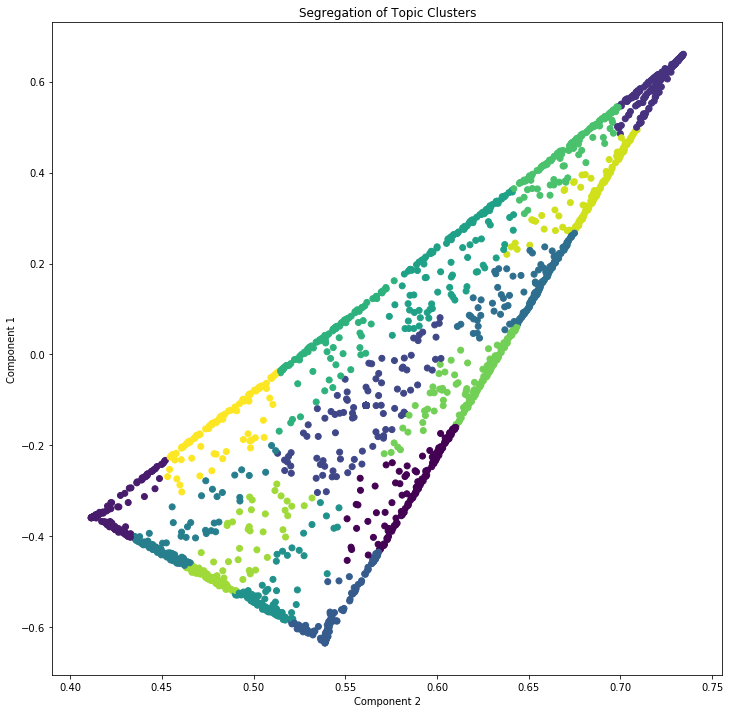

In [19]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [20]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [21]:
# Get similar documents
mytext = ["Helps with stressful days. Usually other things I smoke cause me to be paranoid, however this strain didn't. I felt calm and able to focus on things I was interested in. Didn't really notice I was hungry for about two hours. Just make sure you got your favorite juice around."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['strain', 'hybrid', 'effect', 'sour', 'aroma', 'diesel', 'flavor', 'haze', 'dominant', 'cross', 'sweet', 'genetic', 'blue', 'cerebral', 'body']
Topic Prob Scores of text:  [[1. 0. 0.]]
Most Similar Doc's Probs:   [[1. 0. 0.]]

 delahaze paradise seed  sativa strain bred mango haze california lemon skunk genetics delight commercial grower delahaze energetic effect profile haze sativa still offering sizeable yield moderate flowering time mango citrus note express loudly bring sweet overtone strain s earthy spicy aroma staying true haze genetics sativa delivers uplifting cerebral energy fuel creativity focus happiness taper calm relaxation time
